# Particle Flow Filter (PFF) - Python/TensorFlow Implementation

This notebook implements the Particle Flow Filter for Lorenz 96 model using Python with TensorFlow.
Original MATLAB code by Chih-Chi Hu (chihchi@colostate.edu)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from utils_pff import (
    L96_RK4,
    H_linear,
    H_linear_adjoint,
    generate_L96_trajectory,
    generate_initial_ensemble,
    run_ensemble_no_DA,
    generate_observations,
    compute_prior_covariance,
    build_localization_mask,
    generate_Hx_si,
    compute_grad_log_posterior,
    compute_matrix_kernel_and_gradient,
    adaptive_pseudo_step
)

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## 1. Parameter Setup

In [2]:
# Experiment setup
DA_run = True      # Run ensemble with DA cycles
nt = 200           # Number of integration timesteps
t_start = 0        # Start time (Python uses 0-indexing)
warm_nt = 1000     # Warm up time for Lorenz model
gen_ens = True     # Generate ensemble
np_particles = 30  # Number of particles

# L96 model parameters
dim = 40           # Dimension of Lorenz 96 model
F = 8.0            # Forcing parameter
dt = 0.01          # Time resolution

# Background error covariance (for initial perturbation)
Q = 2 * np.eye(dim)
Q_inv = np.linalg.inv(Q)


# PFF kernel parameter
alpha = 1.0 / np_particles  # Tuning parameter for kernel covariance

# PFF iteration parameters
max_pseudo_step = 150      # Maximum number of iterations
eps_init = 5e-2            # Initial pseudo-timestep size (learning rate)
stop_cri = 1e-3            # Stopping criterion
stop_cri_percentage = 0.05 # Percentage-based stopping criterion
min_learning_rate = 1e-5   # Minimum learning rate

# PFF prior assumptions
io_local = True            # Use localization (recommended)
r_influ = 4                # Localization radius
io_gauss_prior = True      # Use Gaussian prior (recommended)
inflation_fac = 1.25       # Inflation factor for prior covariance
tune_C = 5 / inflation_fac # Covariance tuning for Gaussian mixture



# Linear identity observation setup
dim_interval = 4                # Observation density (every dim_interval-th grid is observed)
obs_input = np.arange(dim_interval-1, dim, dim_interval)  # Python uses 0-indexing

ny_obs = len(obs_input)
inner_domain = [[i] for i in obs_input]  # List of lists for inner domain

nx = 40 

# Observation settings
obs_interval = 4                # Observation frequency (timesteps between observations)
obs_err = 0.3              # Observation error standard deviation
R = obs_err**2 * tf.eye(ny_obs, dtype=tf.float32)

# Observation error
total_obs = nt // obs_interval  # Total number of observations
# obs_rnd = np.random.multivariate_normal(np.zeros(ny_obs), R, total_obs).T

# Storage arrays
if gen_ens:
    prior = np.zeros((dim, np_particles, total_obs))
obs = np.zeros((ny_obs, total_obs))
norm_grad_KL = np.zeros((total_obs, max_pseudo_step))

print(f"Setup complete:")
print(f"  Dimension: {dim}")
print(f"  Particles: {np_particles}")
print(f"  Total timesteps: {nt}")
print(f"  DA interval: {obs_interval}")
print(f"  Total observations: {total_obs}")
print(f"  Number of obs per time: {ny_obs}")

Setup complete:
  Dimension: 40
  Particles: 30
  Total timesteps: 200
  DA interval: 4
  Total observations: 50
  Number of obs per time: 10


## 2. Generate Truth (Warm-up and Integration)

In [3]:
# Initialize truth trajectory
Xt = generate_L96_trajectory(
        dim, warm_nt, nt, dt, F, L96_RK4
)
y_obs, obs_indices, dim_indices = generate_observations(Xt, nt, warm_nt, obs_interval, dim_interval, R, nx=40)

Integrating L96 model...
  Step 200/1200
  Step 400/1200
  Step 600/1200
  Step 800/1200
  Step 1000/1200


In [4]:
X = generate_initial_ensemble(Xt, warm_nt, dim, np_particles, nt, Q) ## Generate the particles

Initial ensemble generated with 30 particles


## 3. Run Ensemble Without DA (Free Run)

In [5]:
XnoDA = run_ensemble_no_DA(X, nt, dt, F, L96_RK4)

Running ensemble without DA (free run)...
  Timestep 50/200
  Timestep 100/200
  Timestep 150/200
Free run complete!


## Main PFF Algorithm - Data Assimilation

In [6]:
if DA_run:
    print("\n" + "="*60)
    print("Starting Particle Flow Filter (PFF) Data Assimilation")
    print("="*60)
    
    t = t_start
    X = X.numpy()
    Xt = Xt.numpy()
    while t < nt - 1:
        # Determine if observation is available
        io_obs = ((t + 1) % obs_interval == 0)
        io_pff = io_obs

        # Step 1: Run the model (forecast)
        X_tf = tf.constant(X[:, :, t], dtype=tf.float32)
        X_next = L96_RK4(X_tf, dt, F)
        X[:, :, t+1] = X_next.numpy()
        
        # Step 2: Generate observation
        if io_obs:
            obs_time = (t + 1) // obs_interval
        
        # Step 3: Particle Flow Filter - Pure TensorFlow
        if io_pff:
            # Calculate prior covariance (TensorFlow)
            X_tmp = X[:, :, t+1]
            X_tmp_tf = tf.constant(X_tmp, dtype=tf.float32)
            
            ### some initialization dataset
            particles = X_tmp_tf

            ######################################################################
            ##### Initialization parameters for the input ########################
            ######################################################################
            B, X_mean_tf = compute_prior_covariance(particles, inflation_fac=1.0)
            C_tf = B/tf.constant(np_particles, dtype=tf.float32)
            mask_tf = build_localization_mask(dim, r_influ)
            C_tf = C_tf * mask_tf

            # All matrix operations in TensorFlow
            C_inv_tf = tf.linalg.inv(C_tf)
            B = C_tf * np_particles
            B_inv_tf = C_inv_tf / np_particles

            # Preconditioner matrix
            qn_tf = B / inflation_fac

            
            # Initialize PFF iteration (TensorFlow)
            s = 0
            ct = 0
            norm_grad_KL[obs_time, 0] = 1e8
            eps = eps_init * tf.ones(max_pseudo_step, dtype=tf.float32)
            
            pseudo_X = tf.identity(X_tmp_tf)
                        
            # Main PFF iteration loop
            while s < max_pseudo_step - 1:
                if s > 0 and norm_grad_KL[obs_time, s-1] <= stop_cri:
                    break
                
                # Evaluate observation operator (identity for observed indices)
                tmp_grad_log_post = compute_grad_log_posterior(
                    X_tmp_tf,
                    y_obs,
                    obs_time,
                    dim_interval,
                    dim_indices,
                    B_inv_tf,
                    X_mean_tf,
                    R,
                    generate_Hx_si,
                    H_linear_adjoint,
                    dim,
                    nx
                )
                

                # Calculate particle flow (grad_KL) - all in TensorFlow
                grad_KL_list = []
                for d in range(dim):
                    ## calculate the K and grad K (Here is different with the original code as we do not use two loop)
                    tmp_K_d, tmp_grad_K_d = compute_matrix_kernel_and_gradient(pseudo_X, d, B, alpha)
                    grad_KL_d = (tf.reduce_sum(tmp_K_d * tmp_grad_log_post[d:d+1, :], axis=1, keepdims=True) + 
                                    tf.reduce_sum(tmp_grad_K_d, axis=1, keepdims=True)) / np_particles
                    grad_KL_list.append(tf.transpose(grad_KL_d))
                grad_KL_tf = tf.concat(grad_KL_list, axis=0)

                
                norm_grad_KL[obs_time, s] = tf.sqrt(tf.reduce_sum(grad_KL_tf**2) / (dim * np_particles)).numpy()

                
                if s % 10 == 0:
                    print(f"    Iteration s={s}, norm={norm_grad_KL[obs_time, s]/norm_grad_KL[obs_time, 0]*100:.2f}%, eps={eps[s].numpy():.2e}")
                
                # Adaptive learning rate and update

                pseudo_X, eps, s, ct, stop, stop_cri = adaptive_pseudo_step(
                    pseudo_X,
                    eps,
                    grad_KL_tf,
                    qn_tf,
                    norm_grad_KL,
                    obs_time,
                    s,
                    ct,
                    stop_cri,  # Added as input parameter
                    stop_cri_percentage,
                    min_learning_rate,
                    max_pseudo_step
                )
            
                if stop:
                    break
            s_end = s
            prior[:, :, obs_time] = X[:, :, t+1]
            X[:, :, t+1] = pseudo_X.numpy()
            
            print(f"  PFF completed in {s_end} iterations")
        
        t += 1
    
    print("\n" + "="*60)
    print("PFF Data Assimilation Complete!")
    print("="*60)


Starting Particle Flow Filter (PFF) Data Assimilation
    Iteration s=0, norm=100.00%, eps=5.00e-02
    Iteration s=10, norm=113.03%, eps=7.50e-02
    Iteration s=20, norm=126.59%, eps=1.13e-01
    [Note] eps changed to tf.Tensor(0.075, shape=(), dtype=float32) , redo iteration
    [Note] eps changed to tf.Tensor(0.05, shape=(), dtype=float32) , redo iteration
    [Note] eps changed to tf.Tensor(0.033333335, shape=(), dtype=float32) , redo iteration
    Iteration s=20, norm=134.03%, eps=3.33e-02
    [Note] eps changed to tf.Tensor(0.022222223, shape=(), dtype=float32) , redo iteration
    [Note] eps changed to tf.Tensor(0.0148148155, shape=(), dtype=float32) , redo iteration
    [Note] eps changed to tf.Tensor(0.009876544, shape=(), dtype=float32) , redo iteration
    [Note] eps changed to tf.Tensor(0.0065843626, shape=(), dtype=float32) , redo iteration
    [Note] eps changed to tf.Tensor(0.004389575, shape=(), dtype=float32) , redo iteration
    [Note] eps changed to tf.Tensor(0.002

## Results Analysis and Visualization


RMSE Statistics:
  DA run - Mean RMSE: 2.6202
  No-DA run - Mean RMSE: 3.1678
  Improvement: 17.29%


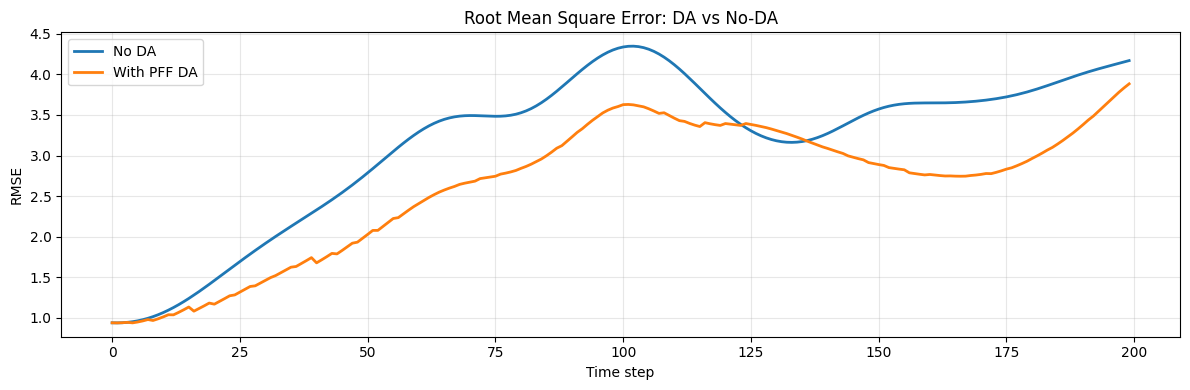

/var/folders/fr/7vt2v5bs1f37tzqpnrrq0l880000gn/T/ipykernel_34064/179721808.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


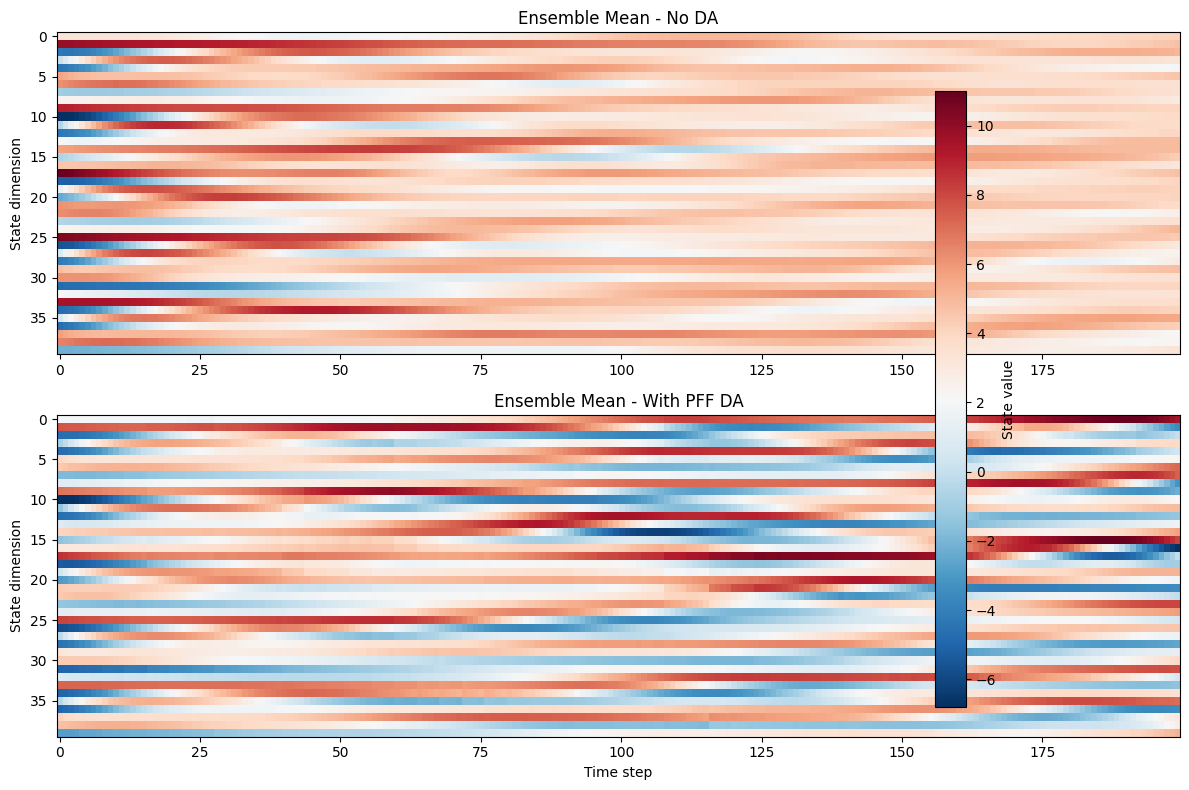

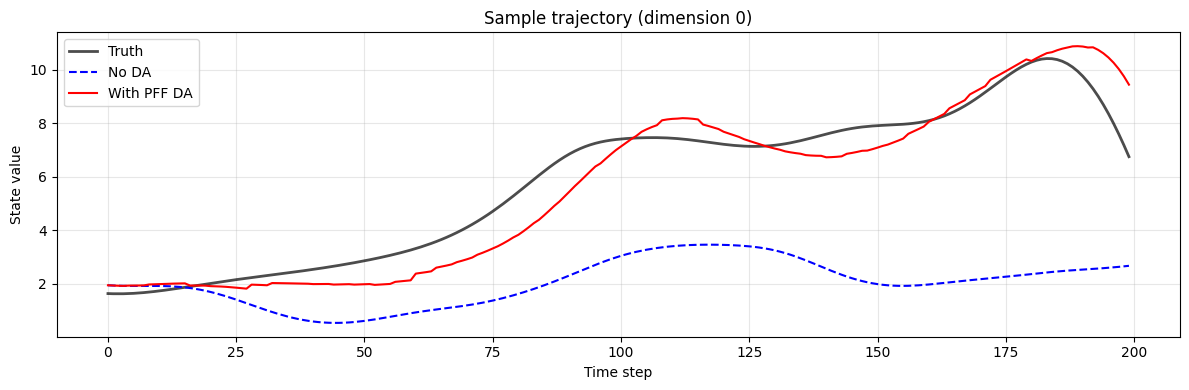

In [7]:
# Calculate RMSE for both DA and no-DA runs
truth = Xt[:, warm_nt:warm_nt+nt]

# Ensemble mean
X_mean_DA = np.mean(X, axis=1)
X_mean_noDA = np.mean(XnoDA, axis=1)

# RMSE over time
rmse_DA = np.sqrt(np.mean((X_mean_DA - truth)**2, axis=0))
rmse_noDA = np.sqrt(np.mean((X_mean_noDA - truth)**2, axis=0))

print(f"\nRMSE Statistics:")
print(f"  DA run - Mean RMSE: {np.mean(rmse_DA):.4f}")
print(f"  No-DA run - Mean RMSE: {np.mean(rmse_noDA):.4f}")
print(f"  Improvement: {(1 - np.mean(rmse_DA)/np.mean(rmse_noDA))*100:.2f}%")

# Plot RMSE comparison
plt.figure(figsize=(12, 4))
plt.plot(rmse_noDA, label='No DA', linewidth=2)
plt.plot(rmse_DA, label='With PFF DA', linewidth=2)
plt.xlabel('Time step')
plt.ylabel('RMSE')
plt.title('Root Mean Square Error: DA vs No-DA')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot ensemble spread
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# No-DA run
axes[0].imshow(X_mean_noDA, aspect='auto', cmap='RdBu_r', interpolation='nearest')
axes[0].set_title('Ensemble Mean - No DA')
axes[0].set_ylabel('State dimension')

# DA run
im = axes[1].imshow(X_mean_DA, aspect='auto', cmap='RdBu_r', interpolation='nearest')
axes[1].set_title('Ensemble Mean - With PFF DA')
axes[1].set_xlabel('Time step')
axes[1].set_ylabel('State dimension')

plt.colorbar(im, ax=axes, label='State value')
plt.tight_layout()
plt.show()

# Plot sample trajectory
sample_dim = 0
plt.figure(figsize=(12, 4))
plt.plot(truth[sample_dim, :], 'k-', linewidth=2, label='Truth', alpha=0.7)
plt.plot(X_mean_noDA[sample_dim, :], 'b--', linewidth=1.5, label='No DA')
plt.plot(X_mean_DA[sample_dim, :], 'r-', linewidth=1.5, label='With PFF DA')
plt.xlabel('Time step')
plt.ylabel('State value')
plt.title(f'Sample trajectory (dimension {sample_dim})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## PFF Convergence Analysis

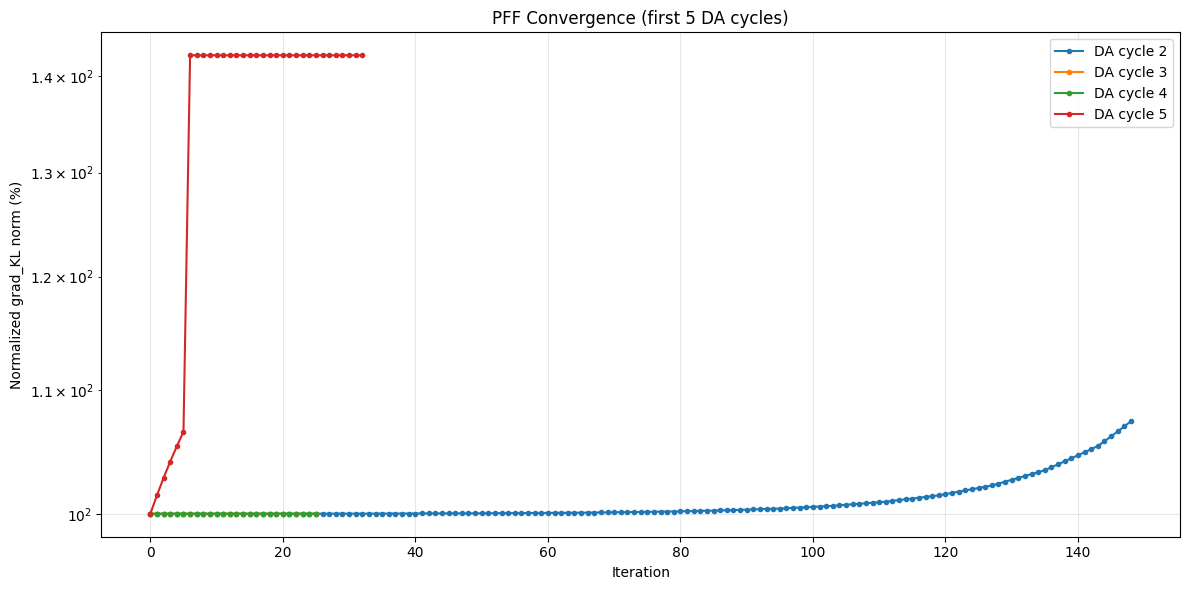


PFF Iteration Statistics:
  Mean iterations per DA cycle: 85.5
  Min iterations: 26
  Max iterations: 149


In [8]:
if DA_run:
    # Plot convergence of gradient norm
    plt.figure(figsize=(12, 6))
    
    for obs_time in range(min(5, total_obs)):  # Plot first 5 DA cycles
        valid_idx = norm_grad_KL[obs_time, :] > 0
        if np.any(valid_idx):
            iterations = np.arange(max_pseudo_step)[valid_idx]
            norms = norm_grad_KL[obs_time, valid_idx]
            plt.semilogy(iterations, norms / norms[0] * 100, 
                        marker='o', markersize=3, label=f'DA cycle {obs_time+1}')
    
    plt.xlabel('Iteration')
    plt.ylabel('Normalized grad_KL norm (%)')
    plt.title('PFF Convergence (first 5 DA cycles)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    iterations_per_cycle = []
    for obs_time in range(total_obs):
        valid_idx = norm_grad_KL[obs_time, :] > 0
        if np.any(valid_idx):
            iterations_per_cycle.append(np.sum(valid_idx))
    
    if iterations_per_cycle:
        print(f"\nPFF Iteration Statistics:")
        print(f"  Mean iterations per DA cycle: {np.mean(iterations_per_cycle):.1f}")
        print(f"  Min iterations: {np.min(iterations_per_cycle)}")
        print(f"  Max iterations: {np.max(iterations_per_cycle)}")

In [9]:
print("\n" + "="*60)
print("Particle Flow Filter Demo Complete!")
print("="*60)


Particle Flow Filter Demo Complete!
